In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import cv2
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import tensorflow as tf

In [2]:
info = pd.read_csv('data/info.csv', header=None)

In [3]:
# 20 annotation scores per frame for each video 
# each row is a new set of annotation scores of each video, with 20 rows per video
# scores are from 1-5
# 2 second long shot-level importance scores
annotations = pd.read_csv('data/annotations.csv', header=None)

In [4]:
# 20 videos
# 5 videos per category

# VT: Changing Vehicle Tire
# VU: Getting Vehicle Unstuck
# GA: Grooming an Animal
# MS: Making Sandwich
# PK: Parkour
# PR: Parade
# FM: Flash Mob Gathering
# BK: Bee Keeping
# BT: Attempting Bike Tricks
# DS: Dog Show

info = pd.read_csv('data/info.csv')

In [5]:
annotations.rename(columns={0: 'filename', 1: 'category', 2: 'annotations'}, inplace=True)

In [6]:
annotations.head()

,filename,category,annotations
0,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
1,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."
2,AwmHb44_ouw,VT,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,..."
3,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
4,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."


In [7]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
filename       1000 non-null object
category       1000 non-null object
annotations    1000 non-null object
dtypes: object(3)
memory usage: 23.6+ KB


In [8]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [9]:
annotations['annotations'] = annotations['annotations'].apply(lambda a: a.split(','))

In [10]:
avg_annotations = []
for fname in annotations.filename.unique():
    values = annotations[annotations['filename'] == fname]['annotations'].values
    float_conversion = np.array(list(values)).astype('float64') 
    avg = np.mean(float_conversion, axis=0)
    avg_annotations.append(avg)

In [11]:
average_scores = pd.DataFrame({'filename': annotations.filename.unique(), 'average_score': avg_annotations})

In [12]:
average_scores.sort_values(by='filename')

,filename,average_score
49,-esJrBWj2d8,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
12,0tmA_C6XwfM,"[1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1..."
18,37rzWOQsNIw,"[3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2..."
13,3eYKfiOEJNs,"[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ..."
29,4wU_LUjG5Ic,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
25,91IHQYk1IQM,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
1,98MoyGZKHXc,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
0,AwmHb44_ouw,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
11,Bhxk-O1Y7Ho,"[2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.9..."
45,E11zDS9XGzg,"[1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6..."


In [13]:
info.columns

Index(['category', 'video_id', 'title', 'url', 'length'], dtype='object')

In [65]:
info[info['video_id'] == '-esJrBWj2d8']

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


In [276]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [14]:
full_df = pd.concat([info.set_index('video_id'), average_scores.set_index('filename')], axis=1, join='inner')

In [15]:
full_df = full_df.reset_index().rename(columns={'index': 'video_id'})

In [16]:
full_df.head()

,video_id,category,title,url,length,average_score
0,AwmHb44_ouw,VT,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
1,98MoyGZKHXc,VT,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
2,J0nA4VgnoCo,VT,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."
3,gzDbaEs1Rlg,VT,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,"[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,XzYM3PfTM4w,VT,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."


In [42]:
avg_scores_sample = full_df[full_df['video_id'] == 'akI8YFjEmUw']['average_score'].values[0]

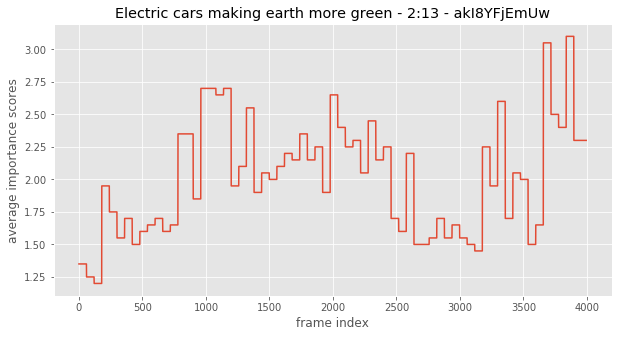

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(avg_scores_sample))
ax.set_xlabel('frame index')
ax.set_ylabel('average importance scores')
ax.set_title('Electric cars making earth more green - 2:13 - akI8YFjEmUw')
ax.plot(x, avg_scores_sample)

In [28]:
def sort_frames(list_of_frames, video_id):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{video_id}/')[1].split('.jpg')[0]))

In [29]:
# 3995 frames
ec_images =  sort_frames(glob.glob('data/frames/akI8YFjEmUw/*'), 'akI8YFjEmUw')

In [20]:
ec_image1 = plt.imread(glob.glob('data/frames/akI8YFjEmUw/*')[500])

In [30]:
full_df

,video_id,category,title,url,length,average_score
0,AwmHb44_ouw,VT,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
1,98MoyGZKHXc,VT,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
2,J0nA4VgnoCo,VT,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."
3,gzDbaEs1Rlg,VT,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,"[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,XzYM3PfTM4w,VT,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
5,HT5vyqe0Xaw,VU,"The stuck truck of Mark, The rut that filled a...",https://www.youtube.com/watch?v=HT5vyqe0Xaw,5:22,"[1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.2..."
6,sTEELN-vY30,VU,BBC - Train crash 2013,https://www.youtube.com/watch?v=sTEELN-vY30,2:29,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
7,vdmoEJ5YbrQ,VU,#453 girl gets van stuck in the back fourty [D...,https://www.youtube.com/watch?v=vdmoEJ5YbrQ,5:29,"[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ..."
8,xwqBXPGE9pQ,VU,Smart Electric Vehicle Balances on Two Wheels,https://www.youtube.com/watch?v=xwqBXPGE9pQ,3:53,"[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ..."
9,akI8YFjEmUw,VU,Electric cars making earth more green,https://www.youtube.com/watch?v=akI8YFjEmUw,2:13,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."


In [45]:
len(avg_scores_sample)

3995

In [52]:
img = cv2.imread(ec_images[0])
hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
(hist.shape, hist.flatten().shape[0])
hist.shape

(8, 8, 8)

In [55]:
type(img)

numpy.ndarray

In [67]:
def rgb_to_hsv_histogram_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [68]:
sample_features = rgb_to_hsv_histogram_features(ec_images, 8)

In [69]:
np.array(sample_features).shape

(3995, 512)